# Load Model

In [4]:
import config

import cv2
import einops
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler


apply_canny = CannyDetector()

config_path = '/home/lolicon/data/dataset/lycoris/model.yaml'
model = create_model(config_path).cpu()


torch_device = 'cuda'

# send to device
model = model.to(torch_device)


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


MultiControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm1.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.14.layer_norm2.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.23.layer_norm2.bias', 'vision_model.encoder.layers.20.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [5]:

from utils.model_loader import load_state_dict

# weight for unet, encoder, decoder, text embedding 
main_ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/pastelMixStylizedAnime_pastelMixFull.safetensors'

# weight for control net 
ctrl_pose_path = '../stable-diffusion-webui/models/ControlNet/control_sd15_openpose.pth'

sd_ckpt = load_state_dict(main_ckpt_path)
sd_ctrl = load_state_dict(ctrl_pose_path)
model.load_multi_state_dict(sd_ckpt, pose_model=sd_ctrl)


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future a

Loaded state_dict from [../stable-diffusion-webui/models/Stable-diffusion/pastelMixStylizedAnime_pastelMixFull.safetensors]
Loaded state_dict from [../stable-diffusion-webui/models/ControlNet/control_sd15_openpose.pth]


# Create Dataset

In [6]:
from data.dataset import CustomDataset

dataset = CustomDataset('/home/lolicon/data/dataset/lycoris/')


# Create Lora Network

In [7]:
from modules.Lora import LoRANetwork, LoRAModule

lora_network = LoRANetwork(unet=model.control_model.pose_model, lora_dim=48, alpha=4.0)
# print(model.control_model.pose_model)



create LoRA for U-Net: 84 modules.



# Ensemble Model

In [8]:

from pytorch_lightning.utilities.distributed import rank_zero_only


class Ensemble(pl.LightningModule):
    def __init__(self, model, lora, learning_rate=1e-5, sd_locked=True, only_mid_control=False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        lora.apply_to(apply_unet=True, apply_text_encoder=False)

        self.model = model
        self.lora = lora

        self.model.log = self.log

        self.lora.train()

        self.learning_rate = learning_rate
        self.model.sd_locked = sd_locked
        self.model.only_mid_control = only_mid_control

    def prepare_grad_etc(sefl):
        self.lora.requires_grad_(True)
        self.model.control_model.requires_grad_(True)
        self.model.model.requires_grad_(True)

    def state_dict(self):
        return self.lora.state_dict()

    def prepare_optimizer_params(self):
        return self.lora.prepare_optimizer_params(self.learning_rate, self.learning_rate)

    def configure_optimizers(self):
        lr = self.learning_rate
        params = self.prepare_optimizer_params()
        opt = torch.optim.AdamW(params, lr=lr)
        return opt

    def training_step(self, batch, batch_idx):
        return self.model.training_step(batch, batch_idx)

    def on_train_batch_start(self, batch, batch_idx):
        self.model.on_train_batch_start(batch, batch_idx)

    def on_train_batch_end(self, *args, **kwargs):
        return self.model.on_train_batch_end(*args, **kwargs)


In [9]:
%load_ext autoreload
%autoreload 2

from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from data.dataset import MyDataset
from pathlib import Path

import pytorch_lightning as pl

class myLogger(ImageLogger):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if not self.disabled:
            self.log_img(pl_module.model, batch, batch_idx, split="train")




root_dir = '/home/lolicon/data/dataset/lycoris/'
num_epochs = 2
num_gpus = 1
batch_size = 2
logger_freq = 20000
learning_rate = 1e-5
sd_locked = True
only_mid_control = False

total_model = Ensemble(model, lora_network, learning_rate, sd_locked, only_mid_control)



dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = myLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(gpus=1, precision=16, callbacks=[logger], enable_checkpointing=False)

# ckpt_cb = ModelCheckpoint(dirpath=Path(root_dir) / 'ckpt',
#                           filename='{epoch:d}',
#                           monitor='train/loss',
#                           mode='max',
#                           save_top_k=-1)

# pbar = TQDMProgressBar(refresh_rate=1)
# callbacks = [ckpt_cb, pbar]

# logger = TensorBoardLogger(save_dir="logs",
#                            name='test',
#                            default_hp_metric=False)

# trainer = Trainer(max_epochs=hparams.num_epochs,
#                   callbacks=callbacks,
#                     resume_from_checkpoint=hparams.ckpt_path,
#                     logger=logger,
#                     enable_model_summary=False,
#                     accelerator='auto',
#                     devices=hparams.num_gpus,
#                     num_sanity_val_steps=1,
#                     benchmark=True,
#                     profiler="simple" if hparams.num_gpus==1 else None,
#                     strategy=DDPPlugin(find_unused_parameters=False) if hparams.num_gpus>1 else None)


trainer.fit(total_model, dataloader)


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more det

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
enable LoRA for U-Net
Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s] 

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('global_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Epoch 0:  10%|█         | 2/20 [00:09<01:26,  4.83s/it, loss=0.068, v_num=13, train/loss_simple_step=0.129, train/loss_vlb_step=0.000469, train/loss_step=0.129, global_step=1.000]     

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0869, v_num=13, train/loss_simple_step=0.035, train/loss_vlb_step=0.000125, train/loss_step=0.035, global_step=19.00, train/loss_simple_epoch=0.0869, train/loss_vlb_epoch=0.000437, train/loss_epoch=0.0869]         Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Epoch 1:  10%|█         | 2/20 [00:09<01:22,  4.59s/it, loss=0.0914, v_num=13, train/loss_simple_step=0.149, train/loss_vlb_step=0.000791, train/loss_step=0.149, global_step=21.00, train/loss_simple_epoch=0.0869, train/loss_vlb_epoch=0.000437, train/loss_epoch=0.0869]  

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0923, v_num=13, train/loss_simple_step=0.00594, train/loss_vlb_step=3.03e-5, train/loss_step=0.00594, global_step=39.00, train/loss_simple_epoch=0.0923, train/loss_vlb_epoch=0.000494, train/loss_epoch=0.0923]         Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Epoch 2:  10%|█         | 2/20 [00:09<01:23,  4.63s/it, loss=0.0918, v_num=13, train/loss_simple_step=0.0966, train/loss_vlb_step=0.000322, train/loss_step=0.0966, global_step=41.00, train/loss_simple_epoch=0.0923, train/loss_vlb_epoch=0.000494, train/loss_epoch=0.0923] 

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.129, v_num=13, train/loss_simple_step=0.0297, train/loss_vlb_step=0.000109, train/loss_step=0.0297, global_step=59.00, train/loss_simple_epoch=0.129, train/loss_vlb_epoch=0.00116, train/loss_epoch=0.129]            Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


Epoch 3:  10%|█         | 2/20 [00:09<01:24,  4.71s/it, loss=0.142, v_num=13, train/loss_simple_step=0.184, train/loss_vlb_step=0.00157, train/loss_step=0.184, global_step=61.00, train/loss_simple_epoch=0.129, train/loss_vlb_epoch=0.00116, train/loss_epoch=0.129]   

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.138, v_num=13, train/loss_simple_step=0.200, train/loss_vlb_step=0.00201, train/loss_step=0.200, global_step=79.00, train/loss_simple_epoch=0.138, train/loss_vlb_epoch=0.000952, train/loss_epoch=0.138]           Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


Epoch 4:  10%|█         | 2/20 [00:09<01:23,  4.63s/it, loss=0.128, v_num=13, train/loss_simple_step=0.148, train/loss_vlb_step=0.000949, train/loss_step=0.148, global_step=81.00, train/loss_simple_epoch=0.138, train/loss_vlb_epoch=0.000952, train/loss_epoch=0.138]

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.156, v_num=13, train/loss_simple_step=0.426, train/loss_vlb_step=0.060, train/loss_step=0.426, global_step=99.00, train/loss_simple_epoch=0.156, train/loss_vlb_epoch=0.00432, train/loss_epoch=0.156]               Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epoch 5:  10%|█         | 2/20 [00:09<01:24,  4.71s/it, loss=0.172, v_num=13, train/loss_simple_step=0.423, train/loss_vlb_step=0.0256, train/loss_step=0.423, global_step=101.0, train/loss_simple_epoch=0.156, train/loss_vlb_epoch=0.00432, train/loss_epoch=0.156]  

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.129, v_num=13, train/loss_simple_step=0.053, train/loss_vlb_step=0.00018, train/loss_step=0.053, global_step=119.0, train/loss_simple_epoch=0.129, train/loss_vlb_epoch=0.00201, train/loss_epoch=0.129]            Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epoch 6:  10%|█         | 2/20 [00:09<01:24,  4.69s/it, loss=0.112, v_num=13, train/loss_simple_step=0.189, train/loss_vlb_step=0.00203, train/loss_step=0.189, global_step=121.0, train/loss_simple_epoch=0.129, train/loss_vlb_epoch=0.00201, train/loss_epoch=0.129]   

/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:338: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()


Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.143, v_num=13, train/loss_simple_step=0.141, train/loss_vlb_step=0.000562, train/loss_step=0.141, global_step=139.0, train/loss_simple_epoch=0.143, train/loss_vlb_epoch=0.00573, train/loss_epoch=0.143]             Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler:  16%|█▌        | 4/25 [00:01<00:08,  2.62it/s]
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Training

In [8]:
from diffusers.optimization import SchedulerType, TYPE_TO_SCHEDULER_FUNCTION
from torch.utils.data import DataLoader
from typing import Optional


def get_scheduler_fix(
    name: Union[str, SchedulerType],
    optimizer: torch.optim.Optimizer,
    num_warmup_steps: Optional[int] = None,
    num_training_steps: Optional[int] = None,
    num_cycles: int = 1,
    power: float = 1.0,
):
  """
  Unified API to get any scheduler from its name.
  Args:
      name (`str` or `SchedulerType`):
          The name of the scheduler to use.
      optimizer (`torch.optim.Optimizer`):
          The optimizer that will be used during training.
      num_warmup_steps (`int`, *optional*):
          The number of warmup steps to do. This is not required by all schedulers (hence the argument being
          optional), the function will raise an error if it's unset and the scheduler type requires it.
      num_training_steps (`int``, *optional*):
          The number of training steps to do. This is not required by all schedulers (hence the argument being
          optional), the function will raise an error if it's unset and the scheduler type requires it.
      num_cycles (`int`, *optional*):
          The number of hard restarts used in `COSINE_WITH_RESTARTS` scheduler.
      power (`float`, *optional*, defaults to 1.0):
          Power factor. See `POLYNOMIAL` scheduler
      last_epoch (`int`, *optional*, defaults to -1):
          The index of the last epoch when resuming training.
  """
  if name.startswith("adafactor"):
    assert type(optimizer) == transformers.optimization.Adafactor, f"adafactor scheduler must be used with Adafactor optimizer / adafactor schedulerはAdafactorオプティマイザと同時に使ってください"
    initial_lr = float(name.split(':')[1])
    # print("adafactor scheduler init lr", initial_lr)
    return transformers.optimization.AdafactorSchedule(optimizer, initial_lr)

  name = SchedulerType(name)
  schedule_func = TYPE_TO_SCHEDULER_FUNCTION[name]
  if name == SchedulerType.CONSTANT:
    return schedule_func(optimizer)

  # All other schedulers require `num_warmup_steps`
  if num_warmup_steps is None:
    raise ValueError(f"{name} requires `num_warmup_steps`, please provide that argument.")

  if name == SchedulerType.CONSTANT_WITH_WARMUP:
    return schedule_func(optimizer, num_warmup_steps=num_warmup_steps)

  # All other schedulers require `num_training_steps`
  if num_training_steps is None:
    raise ValueError(f"{name} requires `num_training_steps`, please provide that argument.")

  if name == SchedulerType.COSINE_WITH_RESTARTS:
    return schedule_func(
        optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=num_cycles
    )

  if name == SchedulerType.POLYNOMIAL:
    return schedule_func(
        optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, power=power
    )

  return schedule_func(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)



unet_lr=1e-4
lr_warmup_steps=0
max_train_steps=10
gradient_accumulation_steps=1
lr_scheduler_num_cycles=0
lr_scheduler_power=0

# Prepare optimizer 

optimizer = torch.optim.AdamW(LoraNet.get_trainable_params(), lr=unet_lr)

# Prepare lr_scheduler

lr_scheduler = get_scheduler_fix(
    "constant", 
    optimizer, 
    num_warmup_steps=lr_warmup_steps,                      
    num_training_steps=max_train_steps * gradient_accumulation_steps,
    num_cycles=lr_scheduler_num_cycles, 
    power=lr_scheduler_power
)

Dataloader = DataLoader(
  dataset=Lora_dataset, 
  batch_size=1,
  shuffle=True
)

max_train_steps = max_train_steps * len(Dataloader)


In [9]:
unet, text_model, LoraNet, optimizer, Dataloader, lr_scheduler = accelerator.prepare(
        unet, text_model, LoraNet, optimizer, Dataloader, lr_scheduler)

unet.requires_grad_(True)
unet.to(accelerator.device, dtype=weight_dtype)
text_model.requires_grad_(True)
text_model.to(accelerator.device)
unet.eval()
text_model.eval()

LoraNet.prepare_grad_etc(text_model, unet)


In [10]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
                                  num_train_timesteps=1000, clip_sample=False)


if accelerator.is_main_process:
    accelerator.init_trackers("network_train")



In [11]:

for epoch in range(100):

    print(f'epoch: {epoch+1}/{10}')
    LoraNet.on_epoch_start(text_model, unet)

    ep_loss = 0.0

    for step, (image, context) in enumerate(Dataloader):
        
        image.to(accelerator.device)

        with torch.set_grad_enabled(train_text_encoder):
            text_embedding = text_model.encode(context)
        
        batch_size = image.shape[0]

        noise = torch.randn_like(image, device=accelerator.device)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size, ), device=image.device)
        timesteps = timesteps.long()

        noisy_latents = noise_scheduler.add_noise(image, noise, timesteps)

        with accelerator.autocast():
            noise_pred = unet.diffusion_model(noisy_latents, timesteps, text_embedding)
        
        loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction='none')
        # loss = loss.mean([1, 2, 3])

        loss = loss.mean()

        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none=True)

        ep_loss += loss.cpu().detach().numpy()
    print(f'epoch loss: {ep_loss}')



epoch: 1/10


RuntimeError: expected scalar type Half but found Float

# Sampling

In [29]:
from modules.prompt_parser import get_learned_conditioning, get_multicond_learned_conditioning
%load_ext autoreload
%autoreload

model.to(accelerator.device)
# LoraNet.to(torch_device)
# model.to(torch_device)

# prompt = ["A cool digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
# prompt_negative = [""]
prompt = ["masterpiece, horn, best quality, laplus, purple eye, seduction, sea, wet, cute face, long hair, 1girl, sexy, 8K, high resolution"]
prompt_negative = ["deformation, ugly, bad quality, distortion"]

height = 512
width = 512
random_seed = 626633957
# import random
# random_seed = random.randint(0, 2147483647)

num_inference_steps = 40
cfg_scale = 7.5
batch_size = 1

# Positive Text Embedding
positive_text_embeddings = model.get_learned_conditioning(prompt)
print(f'the postive text embedding: {positive_text_embeddings}')

# Negative Text Embedding
negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
print(f'the negative text embedding: {negative_text_embeddings}')

# Prep latents
torch.manual_seed(random_seed)
latents = torch.randn((batch_size, 4, height // 8, width // 8), device='cpu')
latents = latents.to(torch_device)

sample_ddim, intermediates = orig_sampler.sample(S=num_inference_steps, 
                             batch_size=1,
                             shape=(4, height // 8, width // 8),
                             conditioning=positive_text_embeddings,
                             x_T=latents,
                             unconditional_conditioning=negative_text_embeddings,
                             unconditional_guidance_scale=cfg_scale)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
the postive text embedding: tensor([[[-0.6994, -0.6919,  0.8025,  ..., -0.4846, -0.3126,  0.0439],
         [ 0.0800,  1.7696, -0.8866,  ..., -1.3788,  1.7314,  1.1783],
         [ 0.0858,  1.8298, -0.8929,  ..., -1.3382,  1.7309,  1.1356],
         ...,
         [ 0.1116,  1.8435, -0.9305,  ..., -1.3187,  1.7429,  1.1195],
         [ 0.1114,  1.8437, -0.9301,  ..., -1.3186,  1.7430,  1.1194],
         [ 0.1116,  1.8444, -0.9308,  ..., -1.3177,  1.7447,  1.1181]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
the negative text embedding: tensor([[[-0.6994, -0.6919,  0.8025,  ..., -0.4846, -0.3126,  0.0439],
         [ 0.4986, -0.6813, -1.2083,  ..., -1.6252, -0.6442, -0.6957],
         [ 0.1060,  1.7827, -0.9069,  ..., -1.3596,  1.7429,  1.1635],
         ...,
         [ 0.0989,  1.8384, -0.9278,  ..., -1.3192,  1.7462,  1.1186],
         [ 0.0989,  1.8390, -0.9271,  ..., -1.3188,  1.

DDIM Sampler: 100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


# Show image

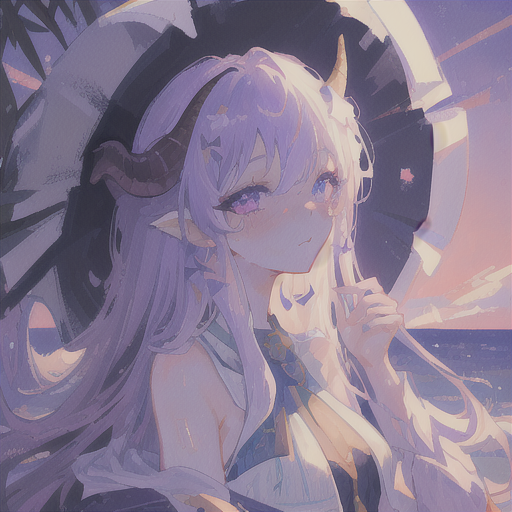

In [ ]:

image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

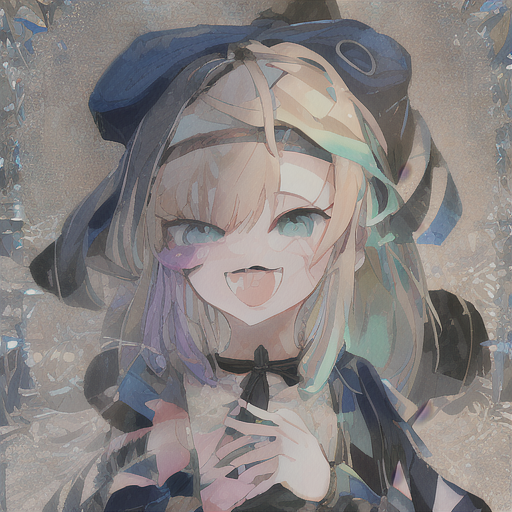

In [23]:
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


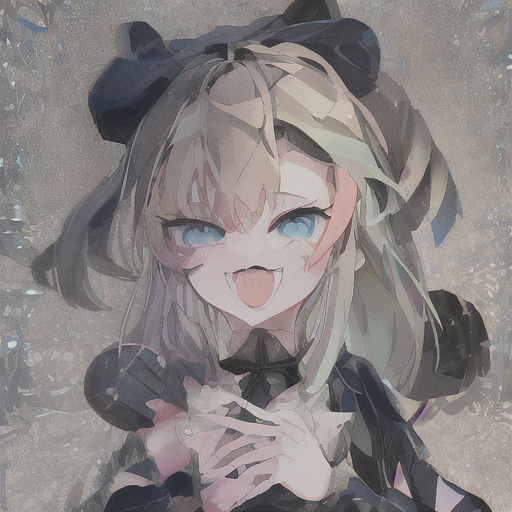

In [30]:
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


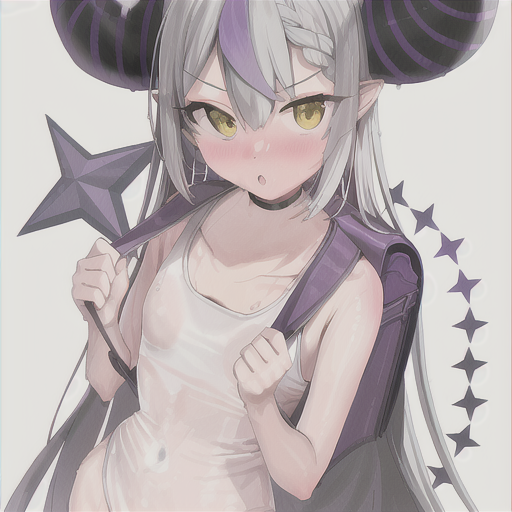

In [19]:

image = model.decode_first_stage(Lora_dataset[4][0].to(accelerator.device).unsqueeze(0))

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [51]:
LoraNet.load_module()
# LoraNet.unload_module()

In [ ]:
import pytorch_lightning as pl
from ldm.util import log_txt_as_img, exists, default, ismap, isimage, mean_flat, count_params, instantiate_from_config
# Set the gradient

class trainModel(pl.LightningModule):
    def __init__(self, LDMmodel, LoraNet):
        super().__init__()
        self.model = LDMmodel
        self.LoraNet = LoraNet
    
    def set_gradient(self):
        self.model.first_stage_model = self.model.first_stage_model.to('cpu')
        self.model.requires_grad_(requires_grad=True)
        self.LoraNet.requires_grad_(requires_grad=True)
    
    def p_losses(self, x_start, t, cond, noise=None):
        
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.model.q_sample(x_start=x_start, t=t, noise=noise)
        model_out = self.model.model(x_noisy, t=t, c_crossattn=[cond])

        loss_dict = {}
        if self.model.parameterization == "eps":
            target = noise
        elif self.model.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(f"Paramterization {self.parameterization} not yet supported")

        loss = self.model.get_loss(model_out, target, mean=False).mean(dim=[1, 2, 3])

        log_prefix = 'train' if self.model.training else 'val'

        loss_dict.update({f'{log_prefix}/loss_simple': loss.mean()})
        loss_simple = loss.mean() * self.model.l_simple_weight

        loss_vlb = (self.model.lvlb_weights[t] * loss).mean()
        loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

        loss = loss_simple + self.model.original_elbo_weight * loss_vlb

        loss_dict.update({f'{log_prefix}/loss': loss})

        return loss, loss_dict

    def forward(self, image, cond):
        # b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
        # assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        cond = self.model.get_learned_conditioning(cond)
        t = torch.randint(0, self.model.num_timesteps, (image.shape[0],), device=self.model.device).long()
        return self.p_losses(image, t, cond)


myModel = trainModel(model, LoraNet)

myModel.set_gradient()

